In [100]:
import numpy as np
import matplotlib.pyplot as plt
from math import log10

In [101]:
data_size = 100

n_satellites = 10

phi_min=0.1
phi_max=1.5
stride=0.1

plot_phi_min=0
plot_phi_max=1

config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": {
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None,
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None,
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None,
                "energy": 5,
                "distance": 700
            }
        }
    }
}

s_gl = config['base']['ground_link']['speed']
s_isl = s_gl * 3

In [102]:
def processing_time_cost(d_in, speed):
    return d_in / speed

def processing_energy_cost(d_in, speed, energy_uptime, energy_io):
    return (energy_io * d_in) + (energy_uptime * (d_in / speed))

def process_data_quadratic(d_in, phi):
    return d_in * phi

def process_data_linear(d_in, tau):
    return d_in + tau

def transmission_time_cost(d_in, speed):
    return d_in / speed

def transmission_energy_cost(d_in, speed, energy, distance):
    return log10(distance) * energy * (d_in / speed)

In [103]:
base_t_obdh = processing_time_cost(data_size, config['base']['obdh']['speed'])
base_e_obdh = processing_energy_cost(data_size, config['base']['obdh']['speed'], config['base']['obdh']['energy_uptime'], config['base']['obdh']['energy_io'])
d_out = process_data_quadratic(data_size, config['base']['obdh']['phi'])

base_t_gl = transmission_time_cost(d_out, config['base']['ground_link']['speed'])
base_e_gl = transmission_energy_cost(d_out, config['base']['ground_link']['speed'], config['base']['ground_link']['energy'], config['base']['ground_link']['distance'])

base_time_cost = base_t_obdh + base_t_gl
base_energy_cost = base_e_obdh + base_e_gl

print("Base time cost: ", base_time_cost, "Base energy cost: ", base_energy_cost)

Base time cost:  12.333333333333334 Base energy cost:  131.4627451339749


In [104]:
n_satellites_values = range(1, n_satellites + 1, 1)
phi_values = np.linspace(stride, 1.6 - stride, int((1.6 - stride) / stride))

quadratic_time_costs = []
quadratic_energy_costs = []

first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
first_transmission_energy_cost = transmission_energy_cost(
    data_size,
    s_isl,
    config['offloading']['user_satellite']['isl']['energy'],
    config['offloading']['user_satellite']['isl']['distance'])

for phi in phi_values:

    n_time_cost = []
    n_energy_cost = []
    for n in n_satellites_values:
        time_cost = first_transmission_time_cost
        energy_cost = first_transmission_energy_cost

        d_out = data_size

        if n == 1:
            time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
            energy_cost += processing_energy_cost(
                d_out,
                config['offloading']['edge_node']['edge_computer']['speed'],
                config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                config['offloading']['edge_node']['edge_computer']['energy_io'])

            d_out = process_data_quadratic(d_out, phi)

        else:
            phi_even = np.power(phi, 1/n)

            for sat_id in range(1, n+1, 1):
                time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
                energy_cost += processing_energy_cost(
                d_out,
                config['offloading']['edge_node']['edge_computer']['speed'],
                config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                config['offloading']['edge_node']['edge_computer']['energy_io'])

                d_out = process_data_quadratic(d_out, phi_even)

                if sat_id != n:
                    time_cost += transmission_time_cost(d_out, s_isl)
                    energy_cost += transmission_energy_cost(
                        d_out,
                        s_isl,
                        config['offloading']['user_satellite']['isl']['energy'],
                        config['offloading']['user_satellite']['isl']['distance'])

        time_cost += transmission_time_cost(d_out, config['base']['ground_link']['speed'])
        energy_cost += transmission_energy_cost(
            d_out,
            config['base']['ground_link']['speed'],
            config['base']['ground_link']['energy'],
            config['base']['ground_link']['distance'])

        n_time_cost.append(time_cost)
        n_energy_cost.append(energy_cost)

    quadratic_time_costs.append(n_time_cost)
    quadratic_energy_costs.append(n_energy_cost)

In [105]:
n_satellites_values = range(1, n_satellites + 1, 1)
phi_values = np.linspace(stride, 1.6 - stride, int((1.6 - stride) / stride))

linear_time_costs = []
linear_energy_costs = []

first_transmission_time_cost = transmission_time_cost(data_size, s_isl)
first_transmission_energy_cost = transmission_energy_cost(
    data_size,
    s_isl,
    config['offloading']['user_satellite']['isl']['energy'],
    config['offloading']['user_satellite']['isl']['distance'])

for phi in phi_values:
    final_data_size = data_size * phi
    diff = final_data_size - data_size

    n_time_cost = []
    n_energy_cost = []
    for n in n_satellites_values:
        time_cost = first_transmission_time_cost
        energy_cost = first_transmission_energy_cost

        tau = diff / n

        d_out = data_size

        if n == 1:
            time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
            energy_cost += processing_energy_cost(
                d_out,
                config['offloading']['edge_node']['edge_computer']['speed'],
                config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                config['offloading']['edge_node']['edge_computer']['energy_io'])

            d_out = process_data_linear(d_out, tau)

        else:

            d_out = data_size
            for sat_id in range(1, n+1, 1):
                time_cost += processing_time_cost(d_out, config['offloading']['edge_node']['edge_computer']['speed'])
                energy_cost += processing_energy_cost(
                d_out,
                config['offloading']['edge_node']['edge_computer']['speed'],
                config['offloading']['edge_node']['edge_computer']['energy_uptime'],
                config['offloading']['edge_node']['edge_computer']['energy_io'])

                d_out = process_data_linear(d_out, tau)

                if sat_id != n:
                    time_cost += transmission_time_cost(d_out, s_isl)
                    energy_cost += transmission_energy_cost(
                        d_out,
                        s_isl,
                        config['offloading']['user_satellite']['isl']['energy'],
                        config['offloading']['user_satellite']['isl']['distance'])

        time_cost += transmission_time_cost(d_out, config['base']['ground_link']['speed'])
        energy_cost += transmission_energy_cost(
            d_out,
            config['base']['ground_link']['speed'],
            config['base']['ground_link']['energy'],
            config['base']['ground_link']['distance'])

        n_time_cost.append(time_cost)
        n_energy_cost.append(energy_cost)

    linear_time_costs.append(n_time_cost)
    linear_energy_costs.append(n_energy_cost)

In [106]:
time_difference = []

for q_phi, l_phi in zip(quadratic_time_costs, linear_time_costs):
    phi_diff = []

    for q_val, l_val in zip(q_phi, l_phi):
        phi_diff.append(q_val - l_val)

    time_difference.append(phi_diff)

energy_difference = []

for q_phi, l_phi in zip(quadratic_energy_costs, linear_energy_costs):
    phi_diff = []

    for q_val, l_val in zip(q_phi, l_phi):
        phi_diff.append(q_val - l_val)

    energy_difference.append(phi_diff)

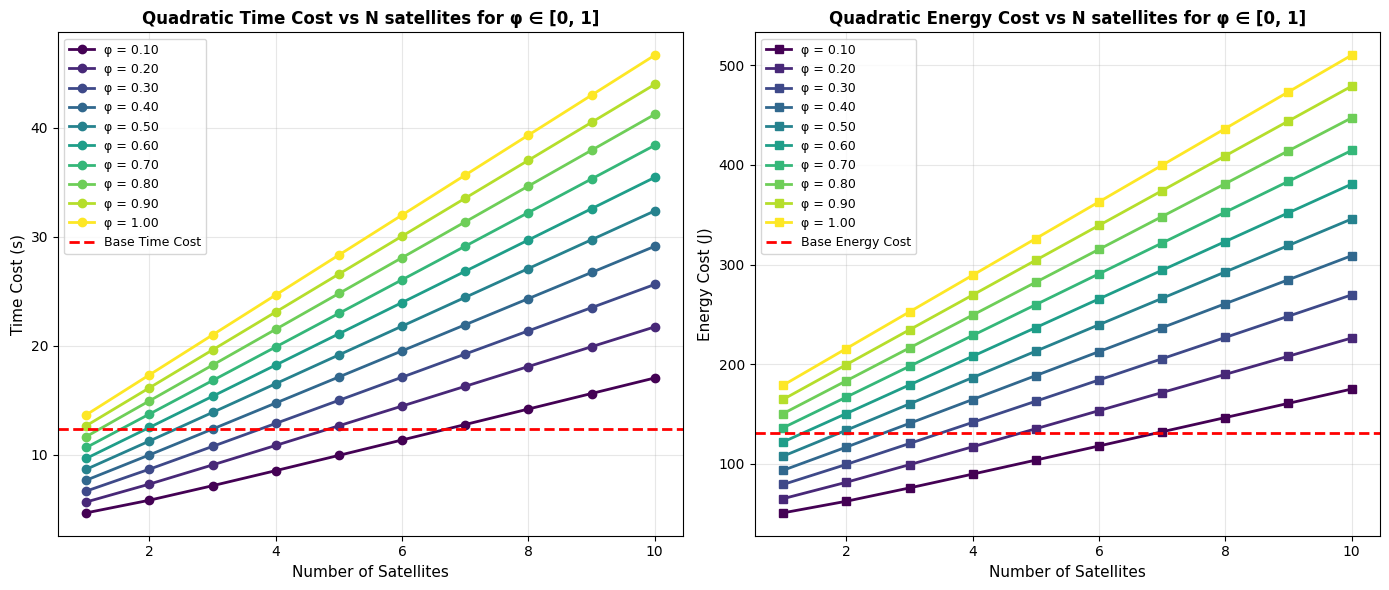

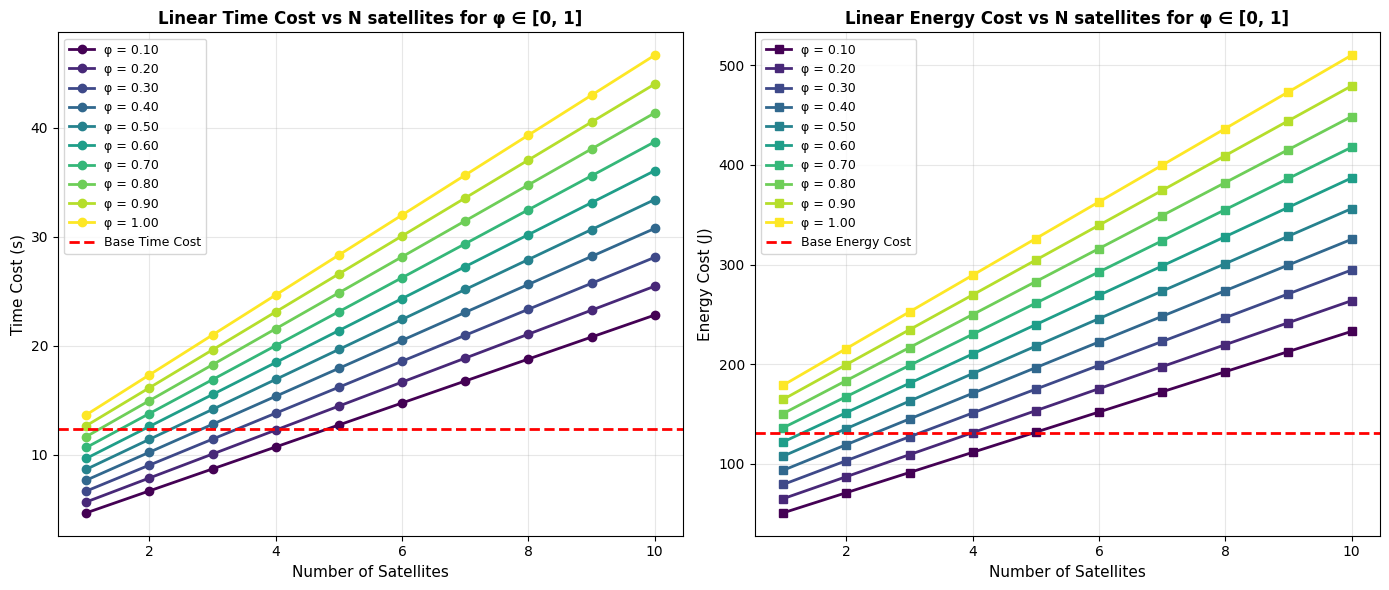

In [107]:
# Convert to numpy arrays for easier indexing
quadratic_time_costs_array = np.array(quadratic_time_costs).T  # Transpose to get shape (n_satellites, phi_values)
quadratic_energy_costs_array = np.array(quadratic_energy_costs).T
linear_time_costs_array = np.array(linear_time_costs).T
linear_energy_costs_array = np.array(linear_energy_costs).T

# Select phi values to display
phi_min_display = plot_phi_min
phi_max_display = plot_phi_max
phi_mask = (phi_values >= phi_min_display) & (phi_values <= phi_max_display)
phi_to_display = phi_values[phi_mask]
phi_indices = np.where(phi_mask)[0]

# Colors for different phi values
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_to_display)))

# ============= QUADRATIC PLOTS =============
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Quadratic Time Cost
for idx, phi_idx in enumerate(phi_indices):
    ax1.plot(n_satellites_values, quadratic_time_costs_array[:, phi_idx],
             marker='o', color=colors[idx],
             label=f'φ = {phi_to_display[idx]:.2f}', linewidth=2)

ax1.axhline(y=base_time_cost, color='red', linestyle='--', linewidth=2, label='Base Time Cost')
ax1.set_xlabel('Number of Satellites', fontsize=11)
ax1.set_ylabel('Time Cost (s)', fontsize=11)
ax1.set_title(f'Quadratic Time Cost vs N satellites for φ ∈ [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=9)

# Plot Quadratic Energy Cost
for idx, phi_idx in enumerate(phi_indices):
    ax2.plot(n_satellites_values, quadratic_energy_costs_array[:, phi_idx],
             marker='s', color=colors[idx],
             label=f'φ = {phi_to_display[idx]:.2f}', linewidth=2)

ax2.axhline(y=base_energy_cost, color='red', linestyle='--', linewidth=2, label='Base Energy Cost')
ax2.set_xlabel('Number of Satellites', fontsize=11)
ax2.set_ylabel('Energy Cost (J)', fontsize=11)
ax2.set_title(f'Quadratic Energy Cost vs N satellites for φ ∈ [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

# ============= LINEAR PLOTS =============
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Linear Time Cost
for idx, phi_idx in enumerate(phi_indices):
    ax3.plot(n_satellites_values, linear_time_costs_array[:, phi_idx],
             marker='o', color=colors[idx],
             label=f'φ = {phi_to_display[idx]:.2f}', linewidth=2)

ax3.axhline(y=base_time_cost, color='red', linestyle='--', linewidth=2, label='Base Time Cost')
ax3.set_xlabel('Number of Satellites', fontsize=11)
ax3.set_ylabel('Time Cost (s)', fontsize=11)
ax3.set_title(f'Linear Time Cost vs N satellites for φ ∈ [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best', fontsize=9)

# Plot Linear Energy Cost
for idx, phi_idx in enumerate(phi_indices):
    ax4.plot(n_satellites_values, linear_energy_costs_array[:, phi_idx],
             marker='s', color=colors[idx],
             label=f'φ = {phi_to_display[idx]:.2f}', linewidth=2)

ax4.axhline(y=base_energy_cost, color='red', linestyle='--', linewidth=2, label='Base Energy Cost')
ax4.set_xlabel('Number of Satellites', fontsize=11)
ax4.set_ylabel('Energy Cost (J)', fontsize=11)
ax4.set_title(f'Linear Energy Cost vs N satellites for φ ∈ [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

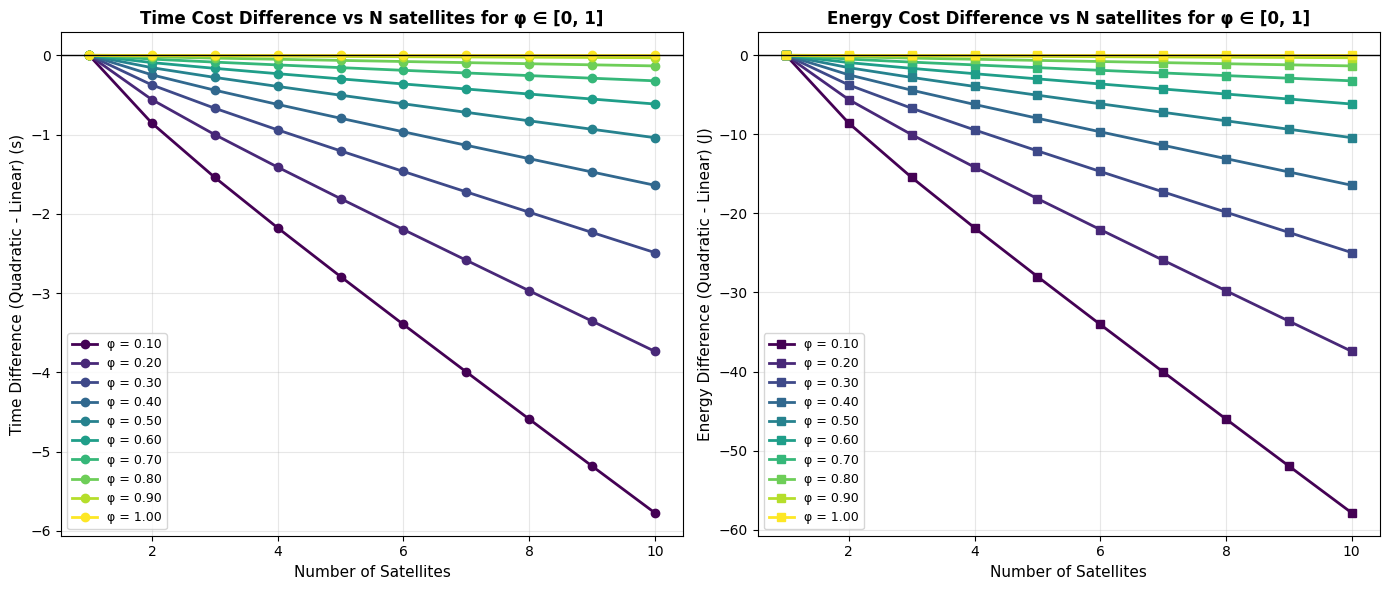

In [108]:
# Convert to numpy arrays and transpose
time_difference_array = np.array(time_difference).T
energy_difference_array = np.array(energy_difference).T

# Select phi values to display
phi_min_display = plot_phi_min
phi_max_display = plot_phi_max
phi_mask = (phi_values >= phi_min_display) & (phi_values <= phi_max_display)
phi_to_display = phi_values[phi_mask]
phi_indices = np.where(phi_mask)[0]

# Colors for different phi values
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_to_display)))

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Time Difference
for idx, phi_idx in enumerate(phi_indices):
    ax1.plot(n_satellites_values, time_difference_array[:, phi_idx],
             marker='o', color=colors[idx],
             label=f'φ = {phi_to_display[idx]:.2f}', linewidth=2)

ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.set_xlabel('Number of Satellites', fontsize=11)
ax1.set_ylabel('Time Difference (Quadratic - Linear) (s)', fontsize=11)
ax1.set_title(f'Time Cost Difference vs N satellites for φ ∈ [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=9)

# Plot Energy Difference
for idx, phi_idx in enumerate(phi_indices):
    ax2.plot(n_satellites_values, energy_difference_array[:, phi_idx],
             marker='s', color=colors[idx],
             label=f'φ = {phi_to_display[idx]:.2f}', linewidth=2)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Number of Satellites', fontsize=11)
ax2.set_ylabel('Energy Difference (Quadratic - Linear) (J)', fontsize=11)
ax2.set_title(f'Energy Cost Difference vs N satellites for φ ∈ [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()